In [1]:
import os
import time
import csv
import numpy as np
from sonnmf.update_H import base as base_H, precomputed_constants, precomputed_constants_with_nesterov
from sonnmf.update_W import base as base_W
from sonnmf.utils import sonnmf_ini, sonnmf_post_it, save_results


In [2]:
jasper_full = np.load('../datasets/jasper_full.npz')['X']
jasper_3d = jasper_full.reshape(-1, 100, 100, order='F')
m, n = jasper_full.shape

In [3]:
max_iters = 10000
r = 20
_lam = 750

In [4]:
ini_filepath = f'../saved_models/jasper_full/r{r}_ini.npz'
save_filepath = '../saved_models/jasper_full/r{}_l{}_mit{}_lmax{}_hm{}.npz'

if os.path.exists(ini_filepath):
    data = np.load(ini_filepath)
    ini_W = data['ini_W']
    ini_H = data['ini_H']
else:
    ini_W = np.random.rand(m, r)
    ini_H = np.random.rand(r, n)
    with open(ini_filepath.format(r), 'wb') as fout:
        np.savez_compressed(fout, ini_W=ini_W, ini_H=ini_H)

In [5]:
def custom_sonnmf(h_update_method, M, W, H, lam=0.0, itermin=100, itermax=1000, early_stop=True, verbose=False, scale_reg=False, inner_iters=1):
    """Calculates NMF decomposition of the M matrix with new acceleration."""

    fscores, gscores, lambda_vals = sonnmf_ini(M, W, H, lam, itermax, scale_reg)

    for it in range(1, itermax + 1):
        # update H
        H = h_update_method(M, W, H, inner_iters)

        # update W
        W = base_W(M, W, H, lambda_vals[it - 1])

        fscores, gscores, lambda_vals, stop_now = sonnmf_post_it(M, W, H, it, fscores, gscores, lambda_vals,
                                                                  early_stop, verbose, scale_reg, lam, itermin)
        if stop_now:
            break

    return W, H, fscores[:it + 1], gscores[:it + 1], np.r_[np.NaN, lambda_vals[1: it + 1]]

In [6]:
results_csv_fp = '../saved_models/jasper_full/output.csv'

fieldnames = ['method', 'lmax', 'time_taken', 'fscore', 'gscore', 'scaled_lambda']
with open(results_csv_fp, mode='w') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()

In [7]:
for lmax in [1, 5, 10, 25]:
    for method, hfunc in enumerate([base_H, precomputed_constants, precomputed_constants_with_nesterov]):
        start_time = time.time()
        W, H, fscores, gscores, lvals = custom_sonnmf(hfunc, jasper_full, ini_W.copy(), ini_H.copy(), lam=_lam, itermax=max_iters, early_stop=False, verbose=False, scale_reg=True, inner_iters=lmax)
        time_taken = time.time() - start_time
        save_results(save_filepath.format(r, _lam, max_iters, lmax, method), W, H, fscores, gscores, lvals)
        
        with open(results_csv_fp, 'a') as csv_file:
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
            writer.writerow({'method': method + 1,
                             'lmax': lmax,
                            'time_taken': time_taken,
                            'fscore': fscores[-1],
                            'gscore': gscores[-1],
                            'scaled_lambda': lvals[-2]})

In [4]:
import pandas as pd
import math

In [5]:
df = pd.read_csv('../output.csv')
df.head()

,method,lmax,time_taken,fscore,gscore,scaled_lambda
0,1,1,5009.927686,3.157201e+09,1.550236e+06,1.527454e+06
1,2,1,4966.647974,3.157201e+09,1.550236e+06,1.527454e+06
2,3,1,4893.486216,3.157201e+09,1.550236e+06,1.527454e+06
3,1,5,5224.506489,1.757987e+12,4.660858e+04,2.828762e+10
4,2,5,5021.732696,1.757988e+12,4.660894e+04,2.828742e+10


In [18]:
df['F'] = df['fscore'] + df['gscore'] * df['scaled_lambda']
df['F_k'] = (1/(m*n)) * df['fscore'] + (2/((math.comb(r, 2)) - r)) * df['gscore'] * df['scaled_lambda']

In [19]:
def load_results(filepath):
    data = np.load(filepath)
    return data['W'], data['H'], data['fscores'], data['gscores'], data['lambda_vals']

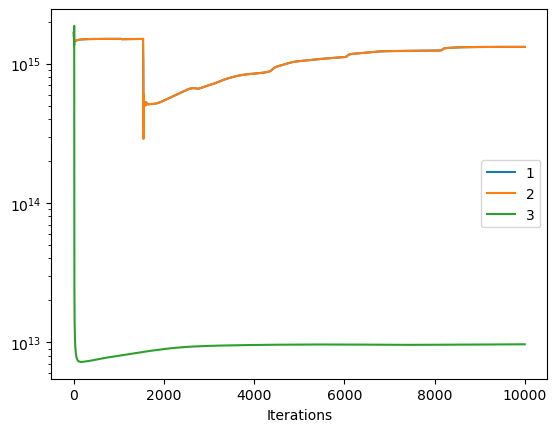

In [29]:
for i, fp in enumerate(['../h_test/r20_l750_mit10000_lmax{5}_hm0.npz', '../h_test/r20_l750_mit10000_lmax5_hm1.npz', '../h_test/r20_l750_mit10000_lmax5_hm2.npz']):
    W, H, fscores, gscores, lambda_vals = load_results(fp)
    fscores = fscores[1:]
    gscores = gscores[1:]
    lambda_vals = lambda_vals[1:]
    total_score = fscores + lambda_vals * gscores
    plt.yscale('log')
    plt.plot(total_score, label='$F(W, H)$')
    # plt.plot(fscores, color='cyan', linewidth=1.5, label='$f(W, H)$')
    # plt.plot(gscores, color='yellow', linewidth=1.5, label='$g(W)$')
    plt.xlabel('Iterations')
plt.legend(['1', '2', '3'])

In [30]:
m

198